# Lab 5b -- Tensorboard
# David Kartchner
## CS 501R

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from subprocess import call



## Create the Computation Graph

In [23]:
# Import data
tf.reset_default_graph()
call("rm -r ./tf_logs", shell=True)
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

sess = tf.InteractiveSession()

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')




with tf.name_scope("Wx_b") as scope:
    # Create the model with better initialized variables
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y")

    #Create weights and biases for first convolution layer
    W_conv1 = weight_variable([5, 5, 1, 32], name="W1_conv")
    b_conv1 = bias_variable([32], name="b1_conv")

    #Create weights and biases for second convolution layer
    W_conv2 = weight_variable([5, 5, 32, 64], name="W2_conv")
    b_conv2 = bias_variable([64], name="b2_conv")

    #Initialize weights and biases for first fully connected layer
    W_fc1 = weight_variable([7 * 7 * 64, 1024], name="W1_fully_connected")
    b_fc1 = bias_variable([1024],name="b1_fully_connected")

    #Initialize weights and biases for second fully connected layer
    W_fc2 = weight_variable([1024, 10], name="W2_fully_connected")
    b_fc2 = bias_variable([10], name="b2_fully_connected")

    #Initialize probability of keeping nodes in dropout layer
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    #Implement first convolution layer with max pooling
    x_image = tf.reshape(x, [-1,28,28,1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    #Implement second convolution layer 
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    #Create first fully connected layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    #Create dropout layer
    with tf.name_scope("Dropout") as scope:
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


with tf.name_scope("Score") as scope:
    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
with tf.name_scope("Loss") as scope:
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))

with tf.name_scope("Optimizer") as scope:
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


with tf.name_scope("Accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Keep track of loss and weights
loss_summary = tf.scalar_summary("Loss", cross_entropy)
acc_summary = tf.scalar_summary("Accuracy", accuracy)

merged = tf.merge_all_summaries()
writer = tf.train.SummaryWriter('./tf_logs', graph=sess.graph)



sess.run(tf.initialize_all_variables())

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x126dec750>> ignored


## Run Network and Print Accuracy

In [32]:
for i in xrange(1500):
    batch = mnist.train.next_batch(50)
    if i%10 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    _,  summary_str = sess.run([train_step, merged]
                                                 ,feed_dict={x: batch[0], 
                                                             y_: batch[1], 
                                                             keep_prob: 0.5})
    writer.add_summary(summary_str, i)
writer.close()

step 0, training accuracy 0.96
step 10, training accuracy 0.94
step 20, training accuracy 1
step 30, training accuracy 0.96
step 40, training accuracy 0.98
step 50, training accuracy 0.96
step 60, training accuracy 0.94
step 70, training accuracy 0.96
step 80, training accuracy 0.98
step 90, training accuracy 1
step 100, training accuracy 1
step 110, training accuracy 1
step 120, training accuracy 1
step 130, training accuracy 0.94
step 140, training accuracy 1
step 150, training accuracy 0.98
step 160, training accuracy 0.96
step 170, training accuracy 0.98
step 180, training accuracy 0.96
step 190, training accuracy 1
step 200, training accuracy 0.98
step 210, training accuracy 0.98
step 220, training accuracy 0.98
step 230, training accuracy 0.98
step 240, training accuracy 1
step 250, training accuracy 0.94
step 260, training accuracy 0.94
step 270, training accuracy 0.98
step 280, training accuracy 0.98
step 290, training accuracy 1
step 300, training accuracy 0.98
step 310, train

In [29]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9727


## Display Computation Graph and Accuracy Plots

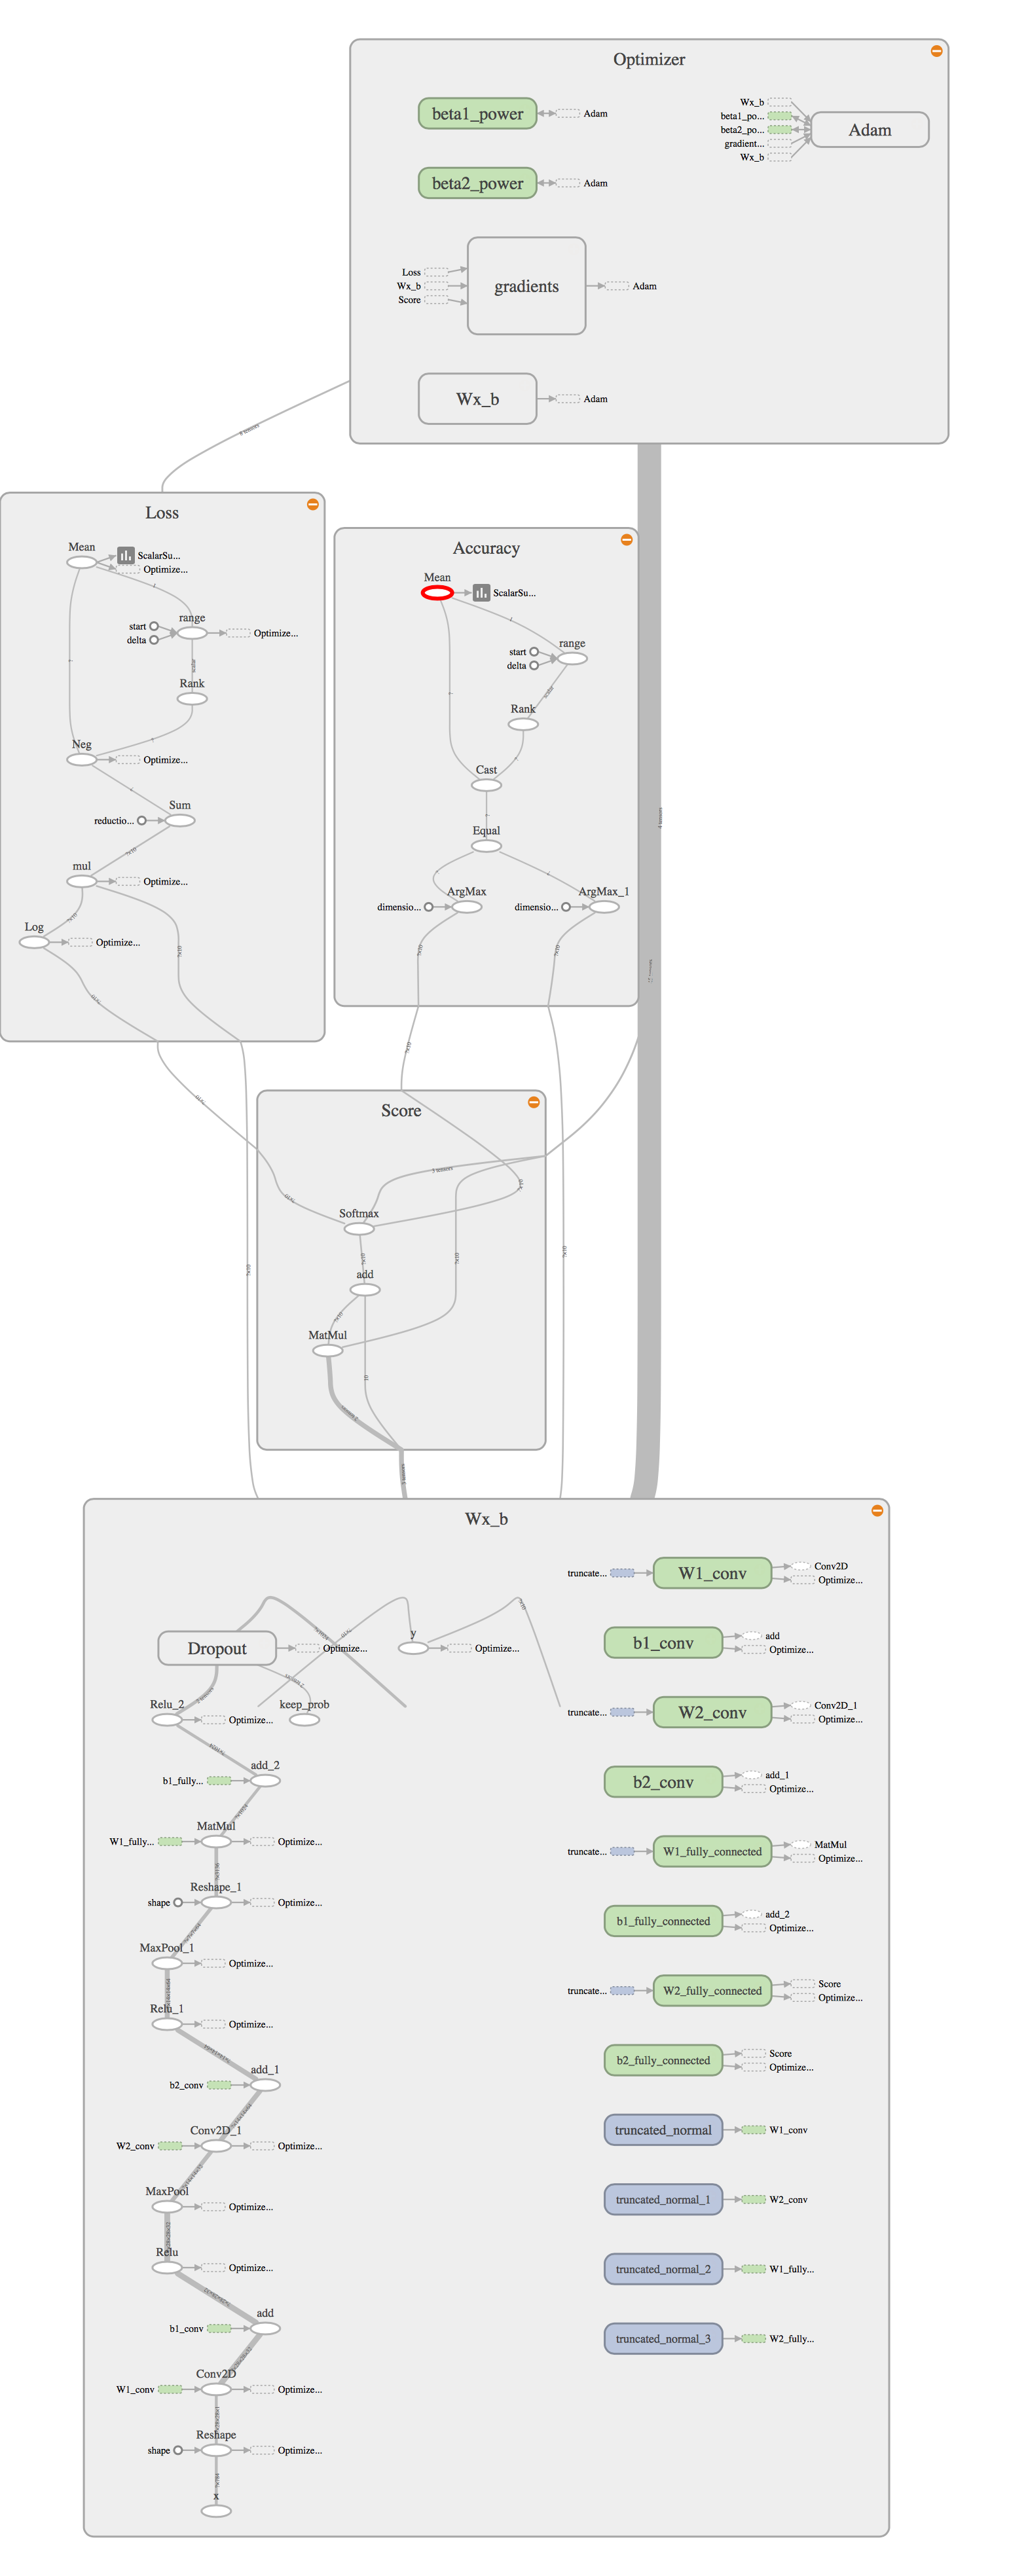

In [26]:
from IPython.display import Image
Image(filename='lab5_tensorboard.png')

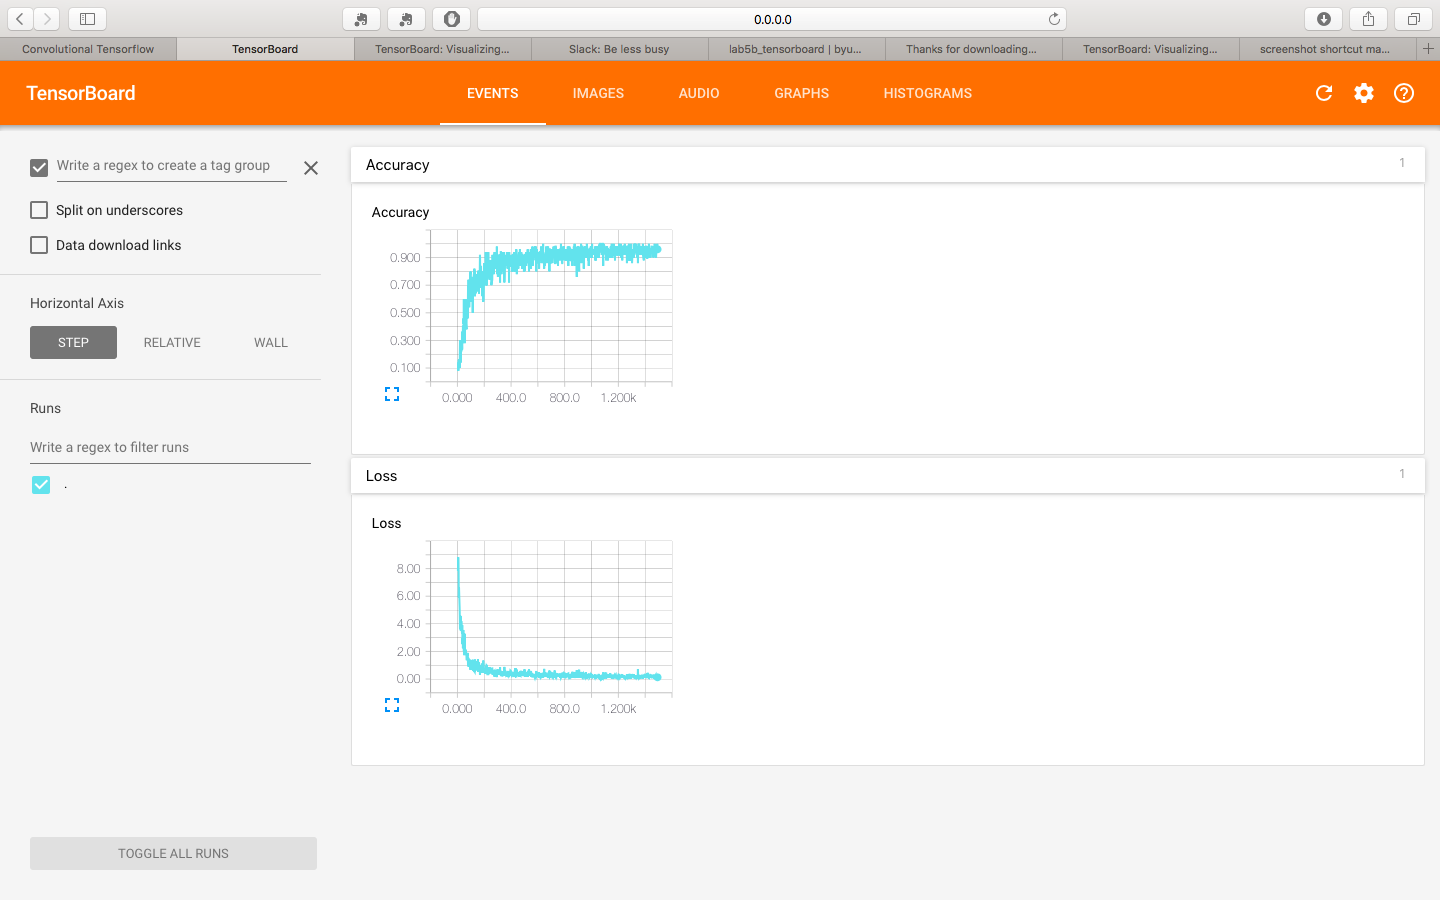

In [28]:
Image("lab5_tensorboard_graphs.png")